In [1]:
import sys
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# plt.style.use('whitegrid')
sns.set_style('whitegrid')

matplotlib.rcParams.update({'figure.figsize': (10, 6)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

In [2]:
# https://www.kaggle.com/shivam2503/diamonds/data
data = pd.read_csv('data/diamonds.csv')

# Remove index and re-order dataset
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data = data[['carat', 'x', 'y', 'z', 'depth', 'table', # 'price', 
             'clarity', 'color',
             'cut']]

# Define cross product (Maybe, Currently just appending the rows clarity to rows color)
# Check if it wants that or cross product and then coded where row has value of cross
# data['clarity-color'] = data['clarity'] + "-" + data['color']

# Define categorical data as ints
# for col in ['color', 'clarity', 'cut']:
#     data[col] = data[col].astype('category');
#     data[col] = data[col].cat.codes

# Generate normalized data
# normalized_data = data.copy();
# for col in ['carat', 'x', 'y', 'z', 'depth', 'table', 'price']:
#     normalized_data[col] = normalized_data[col]/normalized_data[col].max()

# Get 1-hot encoding of clarity-color
# crossed_features = pd.get_dummies(data['clarity-color'], sparse=True);

# # Remove clarity-color form other DataFrames
# data.drop(['clarity-color'], axis=1, inplace=True)
# normalized_data.drop(['clarity-color'], axis=1, inplace=True)

# # Remove the price from one data
# normalized_no_price = normalized_data.drop(['price'], axis=1)

data.head()

,carat,x,y,z,depth,table,clarity,color,cut
0,0.23,3.95,3.98,2.43,61.5,55.0,SI2,E,Ideal
1,0.21,3.89,3.84,2.31,59.8,61.0,SI1,E,Premium
2,0.23,4.05,4.07,2.31,56.9,65.0,VS1,E,Good
3,0.29,4.20,4.23,2.63,62.4,58.0,VS2,I,Premium
4,0.31,4.34,4.35,2.75,63.3,58.0,SI2,J,Good


In [3]:
# normalized_data.plot(kind='box', logy=True)
# plt.show()

In [4]:
# Linear dimensionality reduction: Linear PCA
from sklearn.decomposition import PCA

# [CITE] "04. Dimension Reduction and Images Notebook" by Eric Larson
# i.e. the number of dimensions
test_components_count = 9

def linear_pca(n_components, matrix):
    pca = PCA(n_components=n_components)
    %time pca.fit(matrix)
    return pca


# [CITE] "04. Dimension Reduction and Images Notebook" by Eric Larson

def pca_comp_range(p):
    return np.arange(0,p.n_components)

def explained_var(p):
    return p.explained_variance_ratio_

def cumulative_explained_var(p):
    return np.cumsum(explained_var(p))

def find_nearest_x_for_y(x,y,value):
    index = np.abs(y-value).argmin()
    return x[index]

def find_90_percent_dimension_count(p):
    return find_nearest_x_for_y(pca_comp_range(p), cumulative_explained_var(p),0.9)

def plot_explained_variance(pca):    
    fig, g = plt.subplots()
    cr = pca_comp_range(pca)
    expvar = explained_var(pca)
    cumexpvar = cumulative_explained_var(pca)
    
    g.fill_between(cr, 0, expvar, color='blue', 
        label='individual explained variance')
    g.plot(cr, cumexpvar, color='orange', linestyle='-', marker='', 
        label='cumulative explained variance')
    g.axhline(y=0.9,color='gray',linestyle='--', 
        label='90% accuracy target')
    
    g.set(xlabel='Principal components',ylabel='Explained variance ratio',
        xlim=(0,pca.n_components),ylim=(0,1),
        title='Explained variance of components')
    g.legend(loc='lower right')
    plt.show()

In [5]:
# data_matrix = np.asarray(normalized_no_price)

# test_pca = linear_pca(test_components_count, data_matrix)

In [6]:
# plot_explained_variance(test_pca)

In [7]:
# normalized_no_price.head()

In [8]:
from copy import deepcopy
df_train = deepcopy(data)
df_test = deepcopy(data)

from sklearn.preprocessing import LabelEncoder

##### KERAS #####
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.models import Model

Using TensorFlow backend.


In [9]:
y_train = pd.get_dummies(df_train['cut'])
y_test = pd.get_dummies(df_test['cut'])

numeric_headers = ['carat', 'x', 'y', 'z', 'depth', 'table']

X_train_num =  df_train[numeric_headers].values
X_test_num = df_test[numeric_headers].values

encoders = dict() 
categorical_headers = ['color','clarity','cut']

for col in categorical_headers:
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()
    encoders[col] = LabelEncoder()
    df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
    df_test[col+'_int'] = encoders[col].transform(df_test[col])
    
categorical_headers_ints = [x+'_int' for x in categorical_headers]

In [10]:
# Comment key
# #   = My comments
# ##  = Larson comments
# ### = Changed code


# Columns to generate 1-hots
#  education    X occupation
#  country      X occupation
#  relationship X marital_status X sex
#  race         X sex
cross_columns = [['clarity', 'color']]


# Define the order and layers of the network????
## we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_branch_outputs = []


# For all sets of columns to be crossed
for cols in cross_columns:
    # Creates labels for categorical data. And stores the map
    #  enc.transform translates categorical data to integer
    ## encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    ## create crossed labels
    # Create dataframe of the columns cross product as string data
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    # fits the label encoder to the [x_crossed_train, x_crossed_test]
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    # transform the string to integer for train data
    X_crossed_train = enc.transform(X_crossed_train)
    print(enc.inverse_transform(X_crossed_train))
    # transform the string to integer for test data
    X_crossed_test = enc.transform(X_crossed_test)
    
    # Add elements of x_crossed_train to list of previous x_crossed_train values
    X_ints_train.append( X_crossed_train )
    # Same with test data
    X_ints_test.append( X_crossed_test )
    
    print(X_ints_train[-1])
    ## get the number of categories
    N = max(X_ints_train[-1]+1) ## same as the max(df_train[col])
    ## create embedding branch from the number of categories
    # Create inputs for each of the crossed columns
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    # Adds the Inputs to a list
    all_inputs.append(inputs)
    # Creates an Embedding with input number of categories and output the sqrt(#categories). 
    #  input_length is max matrix size of input
    # Passes inputs into embedding
    
    print('Input dim for embedding', N)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
    # Flatten the dimension of the Embedding
    x = Flatten()(x)
    # Add the Flattened Embedding to the list
    all_branch_outputs.append(x)

# Merge all of the Flattened branches to create a wide_branch
## merge the branches together
### wide_branch = concatenate(all_branch_outputs)
wide_branch = all_branch_outputs[0]

## reset this input branch
all_branch_outputs = []
## add in the embeddings
for col in categorical_headers_ints:
    ## encode as ints for the embedding
    X_ints_train.append( df_train[col].values ) # append NDarrays to list
    X_ints_test.append( df_test[col].values )
    
    ## get the number of categories
    N = max(X_ints_train[-1]+1) ## same as the max(df_train[col])
    # Input defines the tensor shape
    ## create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    # Create a list of all the Inputs
    all_inputs.append(inputs)
    
    # Same as above
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)
    
## also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False, name='numeric_data'))
# Create 20 node dense NN with relu activation
print(all_inputs[-1])
x = Dense(units=5, activation='relu')(all_inputs[-1])
all_branch_outputs.append( x )

## merge the branches together
deep_branch = concatenate(all_branch_outputs)
deep_branch = Dense(units=50,activation='relu')(deep_branch)
deep_branch = Dense(units=10,activation='relu')(deep_branch)
    
final_branch = concatenate([wide_branch, deep_branch])
final_branch = Dense(units=5,activation='sigmoid')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['categorical_accuracy'])


print(y_train.head())


model.fit(X_ints_train+ [X_train_num],
        np.asarray(y_train), epochs=10, batch_size=35, verbose=1)

['SI2_E' 'SI1_E' 'VS1_E' ..., 'SI1_D' 'SI2_H' 'SI2_D']
[22 15 29 ..., 14 25 21]
Input dim for embedding 56
Tensor("numeric_data:0", shape=(?, 6), dtype=float32)
   Fair  Good  Ideal  Premium  Very Good
0     0     0      1        0          0
1     0     0      0        1          0
2     0     1      0        0          0
3     0     0      0        1          0
4     0     1      0        0          0
Epoch 1/10
53940/53940 [==============================] - 4s - loss: 0.0942 - categorical_accuracy: 0.6710     
Epoch 2/10
53940/53940 [==============================] - 3s - loss: 0.0558 - categorical_accuracy: 0.9174     
Epoch 3/10
53940/53940 [==============================] - 4s - loss: 0.0432 - categorical_accuracy: 0.9702     
Epoch 4/10
53940/53940 [==============================] - 3s - loss: 0.0359 - categorical_accuracy: 0.9702     
Epoch 5/10
53940/53940 [==============================] - 3s - loss: 0.0239 - categorical_accuracy: 0.9875     
Epoch 6/10
53940/53940 [=========

In [11]:
y_hat = model.predict(X_ints_test+[X_test_num])

[[ 1610     0     0     0     0]
 [    0  4906     0     0     0]
 [    0     0 21551     0     0]
 [    0     0     0 13791     0]
 [    0     0     0     0 12082]]


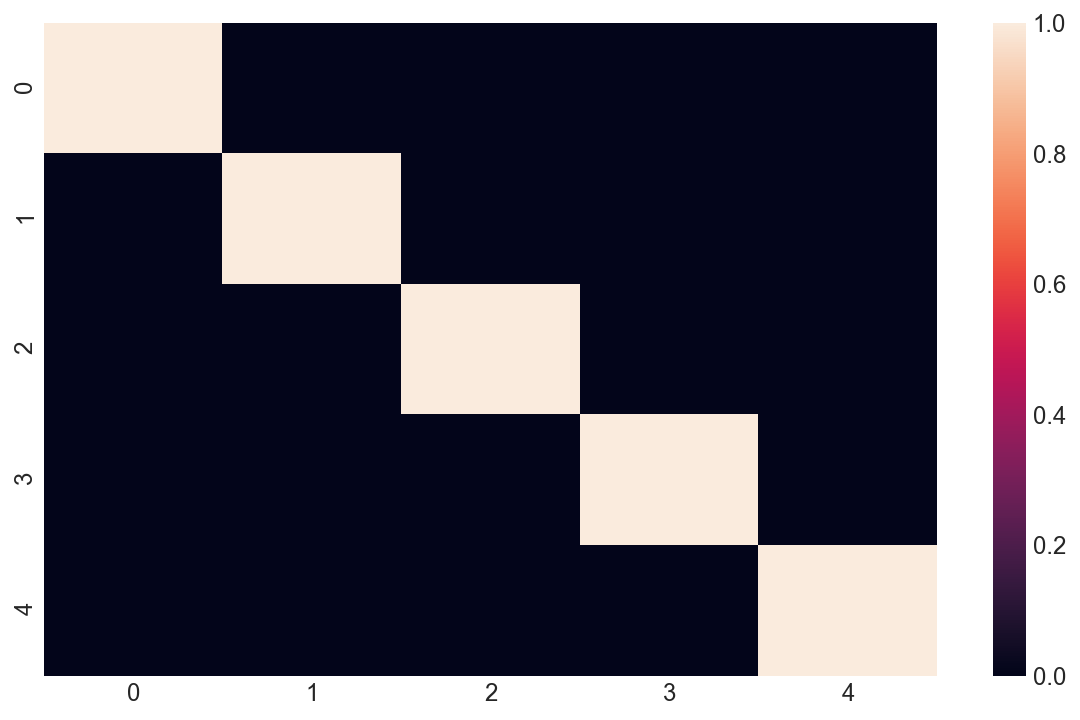

In [13]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(
    np.asarray(y_test).argmax(1),
    y_hat.argmax(1)
)
print(cnf)
cnf_norm = cnf.astype('float') / cnf.sum(axis=1)[:, np.newaxis]
sns.heatmap(cnf_norm)

In [28]:
from sklearn.metrics import roc_auc_score

# gets the column of the maximum for each row
# then converts it to binary (manual one-hot encoding)
y_hat_one_hot = np.zeros(y_hat.shape)
y_hat_one_hot[np.arange(y_hat.shape[0]), y_hat.argmax(1)] = 1

# ROC Area under Curve score
roc_auc_score(
    np.asarray(y_test),
    y_hat_one_hot
)


1.0